In [1]:
# loading libraries
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba
import numpy as np
import scipy.stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
iris = load_iris()
X1= iris.data
l=iris.target

#Calculate pairwise distances named with distX
distX=scipy.spatial.distance.pdist(X1, metric='euclidean')

# Calculate the max vaule of distX
maxd=np.max(distX)


# Rescale data X1 in the interval [0,2] and rename with X, 
X=2*X1/maxd


In [3]:
# PARAMETER-FREE SDD

In [4]:
'''Create functions that calulate the similarity in the high and low dimensional spaces based on degree-distribution, cost function
    and optimization algorithm'''
from time import time
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

MACHINE_EPSILON = np.finfo(np.double).eps

# function of calculating the similarity in the high dimensional space data using degree-distribution
def _joint_probabilities(X):
    # Compute conditional probabilities such that they approximately match
    # the desired perplexity
    dist = pdist(X, "sqeuclidean")
    dist += 1.
    dist **= (-1)
    P= np.maximum(dist / ( np.sum(dist)), MACHINE_EPSILON)
    return P

# Cost function 
def _kl_divergence(params, P, n_samples, n_components,
                   skip_num_points=0, compute_error=True):

    X_embedded = params.reshape(n_samples, n_components)

    # Q is a heavy-tailed distribution: Student's t-distribution
    dist = pdist(X_embedded, "sqeuclidean")
    Dist=dist+ 1.
    dist= Dist**(-1)
    Q = np.maximum(dist / (np.sum(dist)), MACHINE_EPSILON)
    dist1=Dist**(-1)

    # Optimization trick below: np.dot(x, y) is faster than
    # np.sum(x * y) because it calls BLAS

    # Objective: C (Kullback-Leibler divergence of P and Q)
    kl_divergence =np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))

    # Gradient: dC/dY
    # pdist always returns double precision distances. Thus we need to take
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist1)
    for i in range(skip_num_points, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i]),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2*(1 + 1.0) 
    grad *= c

    return kl_divergence, grad

# Optimization algorithm
def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.5, learning_rate=7, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
        # compute the error when needed
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[parameter-free SDD] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[parameter-free SDD] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[parameter-free SDD] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i



class Parameter_FREE_SDD(BaseEstimator):
    
    # The optimization algorithm is been inpied by t-SNE (http://www.cs.toronto.edu/~hinton/absps/tsne.pdf)
    #Control the number of exploration iterations with early_exaggeration on
    _EXPLORATION_N_ITER = 300

    # Control the number of iterations between progress checks
    _N_ITER_CHECK =50
    def _fit(self, X, skip_num_points=0):
        random_state=None
    # compute the joint probability distribution for the input space
        n_samples=X.shape[0]
#         distances = pairwise_distances(X, metric=self.metric,squared=True)
        P = _joint_probabilities(X)

        random_state = check_random_state(random_state)

        X_embedded = 1e-4 * random_state.randn(
                n_samples, 2).astype(np.float32)

        return self._parameter_free_SDD(P, n_samples,X_embedded=X_embedded,skip_num_points=skip_num_points)

    def _parameter_free_SDD(self, P, n_samples, X_embedded, skip_num_points=0):
        """Runs SDD."""
        
        # The optimization algorithm that
        # we use is batch gradient descent with two stages:
        # * initial optimization with early exaggeration and momentum at 0.5
        # * final optimization with momentum at 0.8
        params = X_embedded.ravel()

        opt_args = {
            "it": 0,
            "n_iter_check": 50,
            "min_grad_norm": 1e-7,
            "learning_rate": 7,
            "verbose": 0,
            "kwargs": dict(skip_num_points=skip_num_points),
            "args": [P, n_samples, 2],
            "n_iter_without_progress": 300,
            "n_iter": 300,
            "momentum": 0.8,
        }
        obj_func = _kl_divergence

        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                      **opt_args)
#         if self.verbose:
#             print("KL divergence after %d iterations with early "
#                   "exaggeration: %f" % (it + 1, kl_divergence))

        # Learning schedule (part 2): disable early exaggeration and finish
        # optimization with a higher momentum at 0.8
        P /= 1
        remaining =2000 - 300
        if it < 300 or remaining > 0:
            opt_args['n_iter'] = 2000
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = 300
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                          **opt_args)

        # Save the final number of iterations
        self.n_iter_ = it

#         if verbose:
#             print("KL divergence after %d iterations: %f"
#                   % (it + 1, kl_divergence))

        X_embedded = params.reshape(n_samples, 2)
        self.kl_divergence_ = kl_divergence

        return X_embedded


In [5]:

print('working on it...')
'''Calculate the pairwise distances in high space and name with A (We need to calculate the Kendall's Tau
     between pairwise distances in high dimensional space(A) and low dimensional space (B))'''

A=scipy.spatial.distance.pdist(X, metric='euclidean')

embedding = Parameter_FREE_SDD()
#  Degree_of_freedom=1, as it does not need to be tunned
X_Parameter_FREE_SDD = embedding._fit(X)
B=scipy.spatial.distance.pdist(X_Parameter_FREE_SDD, metric='euclidean')
#Kendall's Tau
k_TAU=scipy.stats.kendalltau(A, B)
print('performance of parameter_free SDD is :',k_TAU)





working on it...
performance of parameter_free SDD is : KendalltauResult(correlation=0.9673379703444407, pvalue=0.0)


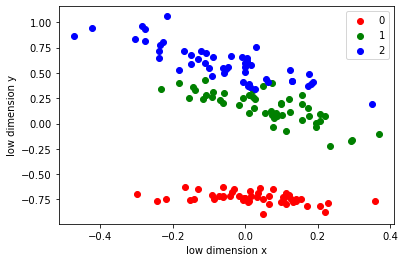

In [6]:
# Visulize the two-dimensional data 
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'brown', 'orange', 'purple'
target_ids=range(len(l))
labels=np.unique(l)
for i, c, label in zip(target_ids, colors, labels):
    plt.scatter(X_Parameter_FREE_SDD[l == i, 0], X_Parameter_FREE_SDD[l == i, 1], c=c, label=int(label))
plt.legend()
plt.xlabel('low dimension x')
plt.ylabel('low dimension y')
plt.show()